---
# Most Exciting Input generator
---

In [1]:
import torch
from example_models import MNIST_model, show_image, show_image_grid
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

import sys
sys.path.append('..')

# First build and train your models

In [2]:
model = MNIST_model
load = True

model1 = model(name="mnist_model1", device=device, load=load)
model2 = model(name="mnist_model2", device=device, load=load)

if not load:
    model1.train(epochs=10)
    model2.train(epochs=10)
model1.evaluate()
model2.evaluate()
model1.save()
model2.save()

Loading mnist_model1...
Loading mnist_model2...
Test Accuracy on mnist_model1: 96.69%
Test Accuracy on mnist_model2: 96.68%
Saved mnist_model1.
Saved mnist_model2.


In [3]:
def operation(unit_n):
    def forward(x):
        output = model1(x)
        output = torch.flatten(output, 1)
        return output[:, unit_n]
    return forward

# Import and instantiate MEI

In [4]:
from meitorch import mei
Mei = mei.MEI(operation=operation(2), shape=(1, 28, 28), device=device)

# Define configuration for generation

In [5]:
from meitorch.tools.schedules import LinearSchedule, ConstantSchedule, OctaveSchedule

In [6]:
image_mei_config = dict(
    iter_n=100,
    n_samples=10, # number of samples per batch
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=2,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,


    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        step_size=1
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser='tv',
    denoiser_params=dict(
        reguralization_scaler=0.1,
        lr=0.1,
        num_iters=100,
    ),
)

# Generate *most exciting input*

In [7]:
meip = Mei.generate_image_based(**image_mei_config)

100%|██████████| 100/100 [00:00<00:00, 1971.92it/s]


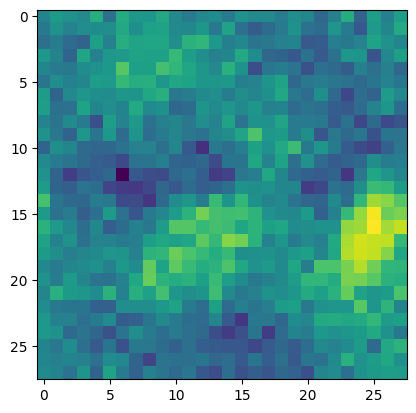

1.0


In [8]:
i = 0
from matplotlib.pyplot import imshow, show
imshow(meip.get_image()[i][0].detach().numpy())
show()
print(meip.get_activation()[i])

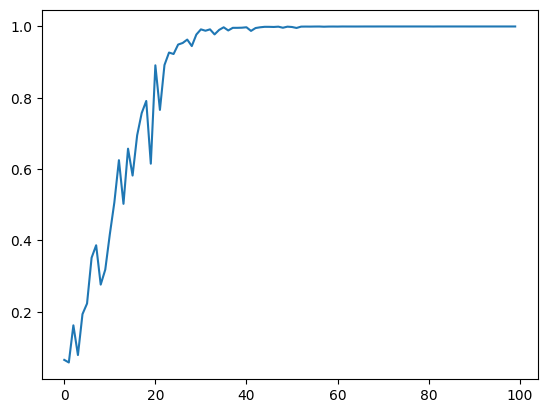

In [49]:
history = meip.loss_history

from matplotlib.pyplot import plot, show
plot(history)

In [6]:
var_mei_config = dict(
    iter_n=500,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    #variational
    distribution='normal',
    n_samples_per_batch=(32,),
    fixed_stddev=0.2,
)

generator_mei_config = dict(
    iter_n=1000,
    save_every=100,        # save image every n iterations
    net="mlp",           # "mlp", "cnn", custom

    n_samples_per_batch=10,
)

In [7]:
meip = Mei.generate_variational(**var_mei_config)

ValueError: optimizer got an empty parameter list

In [ ]:
meip = Mei.generate_variational(image_mei_config)
show_image(meip.get_image(), text="MEI", activation=meip.get_activation())

In [ ]:
meip = Mei.generate_nn_based(image_mei_config)
show_image(meip.get_image(), text="MEI", activation=meip.get_activation())

In [5]:
#list neuron query for multiple dimension output
meip_complex = Mei.generate([2]) # for 2 dimensions would be [0,1] for example

#no neuron query to generate for all neurons
meip_all = Mei.generate()

#custom neuron query
meip_custom = Mei.generate(lambda index: index[-1]%2==0)

100%|██████████| 1000/1000 [00:00<00:00, 8488.74it/s]


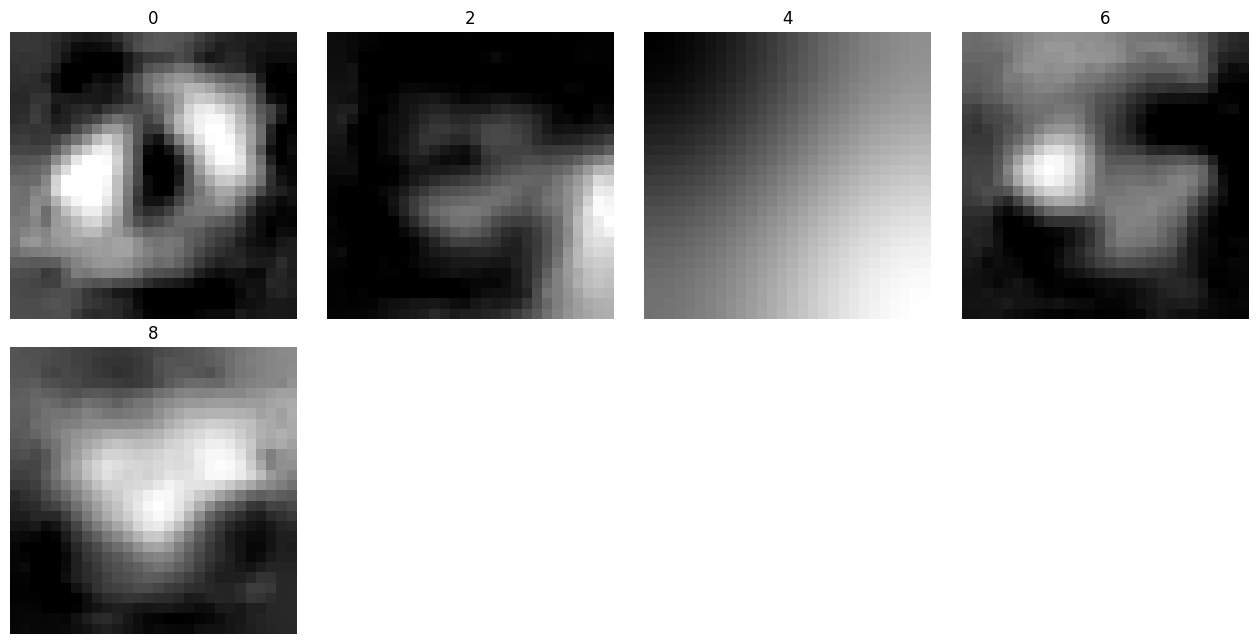

In [6]:
show_image_grid(
    [m.image[0] for m in meip_custom],
    texts=[f"{i}" for i in range(0, 10, 2)],
    activations=[m.activation for m in meip_custom])

# Generate gradient receptive field

100%|██████████| 1/1 [00:00<00:00, 1190.21it/s]


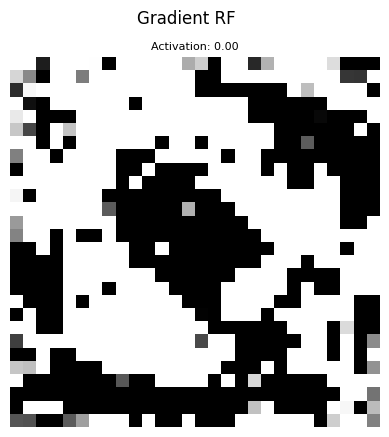

In [16]:
gradrf = Mei.gradient_rf(0,
                         iter_n=1000,
                         start_sigma=1.5,
                         end_sigma=0.01,
                         start_step_size=3.0,
                         end_step_size=0.125,
                         precond=0,
                         step_gain=0.1,
                         jitter=0,
                         blur=True,
                         norm=-1,
                         train_norm=-1,
                         clip=True)
show_image(gradrf.image[0], text="Gradient RF", activation=gradrf.activation)

# Find most excitatory samples from dataset

100%|██████████| 60000/60000 [00:09<00:00, 6524.77it/s]


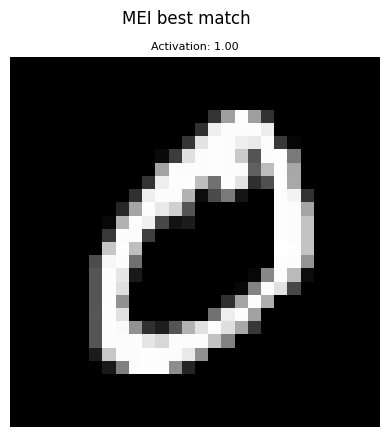

In [9]:
meip_best_match_activation, meip_best_match_image = meip.best_match(model1.train_loader)
show_image(meip_best_match_image, text="MEI best match", activation=meip_best_match_activation)

# Compare original and *masked/shifted* responses

100%|██████████| 1/1 [00:00<00:00, 447.01it/s]


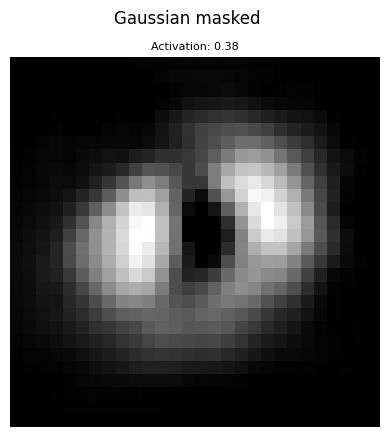

In [6]:
# Gaussian mask

gaussian_masked_resp, gaussian_masked_image = meip.masked_responses(mask="gaussian", factor=3)
show_image(gaussian_masked_image[0], text="Gaussian masked", activation=gaussian_masked_resp)

100%|██████████| 1/1 [00:00<00:00, 332.43it/s]


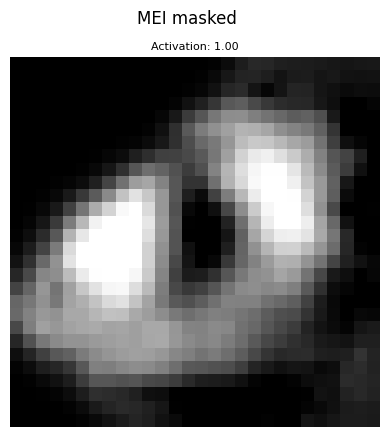

In [7]:
# MEI mask

mei_masked_resp, mei_masked_image = \
    meip.masked_responses(mask="mei",
                         delta_thr=0.2,     # threshold on the difference from mean
                         size_thr=80,       # threshold for size of blobs
                         expansion_sigma=1, # mask size expansion sigma
                         expansion_thr=0.3, # mask size expansion threshold
                         filter_sigma=1)    # sigma for final gaussian blur
show_image(mei_masked_image[0], text="MEI masked", activation=mei_masked_resp)

100%|██████████| 1/1 [00:00<00:00, 246.80it/s]


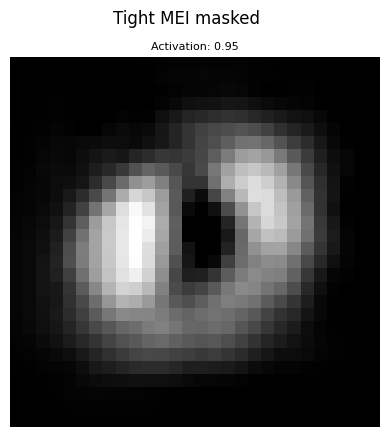

In [21]:
# Tight MEI mask

t_mei_masked_resp, t_mei_masked_image = \
    meip.masked_responses(mask="mei_tight",
                          stdev_size_thr=1,           #fraction of standard dev threshold for size of blobs
                          filter_sigma=3,             #sigma for final gaussian blur
                          target_reduction_ratio=0.99) #reduction ratio to achieve for tightening the mask
show_image(t_mei_masked_image[0], text="Tight MEI masked", activation=t_mei_masked_resp)

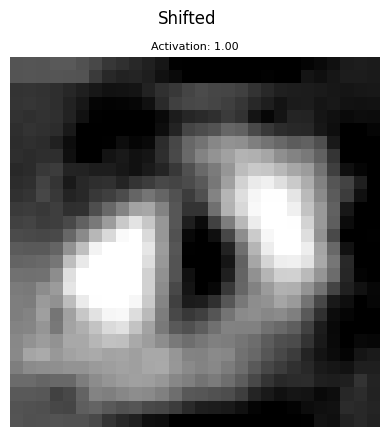

In [12]:
# Shifted

shifted_resp, shifted_image = meip.shifted_response(x_shift=2, y_shift=3)
show_image(shifted_image[0], text="Shifted", activation=shifted_resp)

# Create Gabor stimuli and find most excitatory ones

In [13]:
gabor = mei.Gabor(models=[model1, model2], shape=(1, 28, 28))

Creating gabors


72800it [01:32, 787.73it/s]


Evaluating gabors


72800it [00:06, 11195.63it/s]


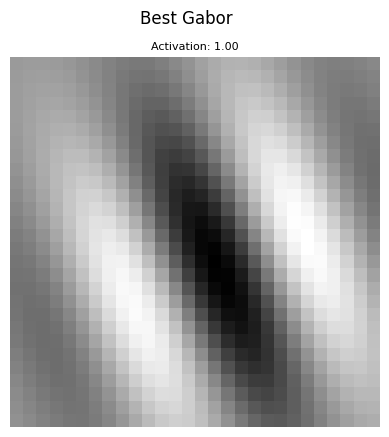

In [14]:
best_gabor = gabor.best_gabor(0)
show_image(best_gabor.image, text="Best Gabor", activation=best_gabor.activation)

# Find optimal Gabor stimuli

100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


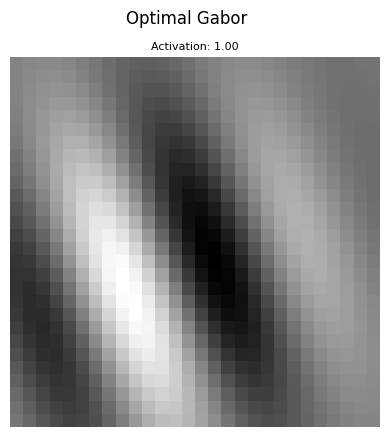

In [15]:
optimal_gabor = gabor.optimal_gabor(0)
show_image(optimal_gabor.image, text="Optimal Gabor", activation=optimal_gabor.activation)

# Compute spatial frequency

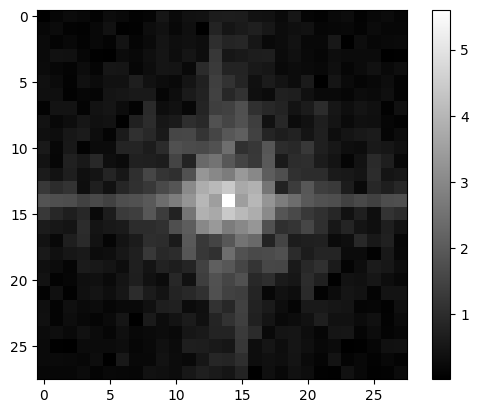

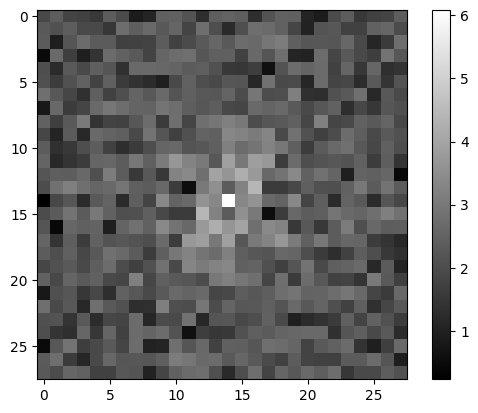

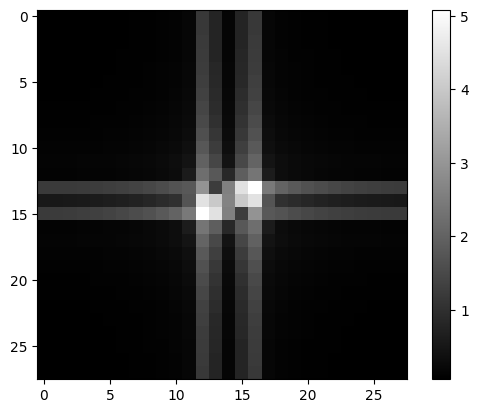

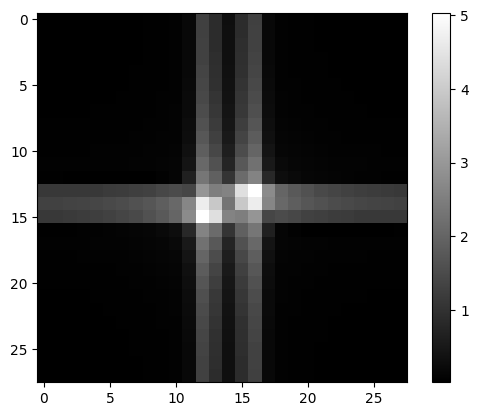

In [18]:
freq_cols_mei, freq_rows_mei, magnitude_spectrum_mei = meip.spatial_frequency()

freq_cols_gradrf, freq_rows_gradrf, magnitude_spectrum_gradrf = gradrf.spatial_frequency()

freq_cols_best_gabor, freq_rows_best_gabor, magnitude_spectrum_best_gabor = best_gabor.spatial_frequency()

freq_cols_optimal_gabor, freq_rows_optimal_gabor, magnitude_spectrum_optimal_gabor = optimal_gabor.spatial_frequency()